In [1]:
!pip install numpy
!pip install matplotlib
!pip install IPython

In [2]:

import numpy as np
import matplotlib.pyplot as plt
import time
from IPython import display
import random

In [3]:
methods = ['DynProg', 'ValIter']

# Some colours
LIGHT_RED    = '#FFC4CC'
LIGHT_GREEN  = '#95FD99'
BLACK        = '#000000'
WHITE        = '#FFFFFF'
LIGHT_PURPLE = '#E8D0FF'


In [13]:
class Maze:

    # Actions
    STAY       = 0
    MOVE_LEFT  = 1
    MOVE_RIGHT = 2
    MOVE_UP    = 3
    MOVE_DOWN  = 4

    # Give names to actions
    actions_names = {
        STAY: "stay",
        MOVE_LEFT: "move left",
        MOVE_RIGHT: "move right",
        MOVE_UP: "move up",
        MOVE_DOWN: "move down"
    }

    # Reward values 
    STEP_REWARD = -0.01         #small penality for every step to incourage finding the exit faster (or being eaten)
    GOAL_REWARD = 100         #possitive reward for exiting the maze
    IMPOSSIBLE_REWARD = -1   #penalizing impossible moves
    MINOTAUR_REWARD = -10     #TODO

    def __init__(self, maze):
        """ Constructor of the environment Maze.
        """
        self.maze                     = maze
        self.actions                  = self.__actions()
        self.states, self.map         = self.__states()
        self.n_actions                = len(self.actions)
        self.n_states                 = len(self.states)
        print(self.n_states)
        self.transition_probabilities = self.__transitions()
        self.rewards                  = self.__rewards()

    def __actions(self):
        actions = dict()
        actions[self.STAY]       = (0, 0)
        actions[self.MOVE_LEFT]  = (0,-1)
        actions[self.MOVE_RIGHT] = (0, 1)
        actions[self.MOVE_UP]    = (-1,0)
        actions[self.MOVE_DOWN]  = (1,0)
        return actions

    def __states(self):
        
        states = dict()
        map = dict()
        s = 0
        for i in range(self.maze.shape[0]):
            for j in range(self.maze.shape[1]):
                for k in range(self.maze.shape[0]):
                    for l in range(self.maze.shape[1]):
                        if self.maze[i,j] != 1:
                            states[s] = ((i,j), (k,l))
                            map[((i,j), (k,l))] = s
                            s += 1
        
        states[s] = 'Eaten'
        map['Eaten'] = s
        s += 1
        
        states[s] = 'Win'
        map['Win'] = s
        return states, map

    def move(self, state, action):               
        """ Makes a step in the maze, given a current position and an action. 
            If the action STAY or an inadmissible action is used, the player stays in place.
        
            :return list of tuples next_state: Possible states ((x,y), (x',y')) on the maze that the system can transition to.
        """
        
        if self.states[state] == 'Eaten' or self.states[state] == 'Win': # In these states, the game is over
            return [self.states[state]]
        
        else: # Compute the future possible positions given current (state, action)
            row_player = self.states[state][0][0] + self.actions[action][0] # Row of the player's next position 
            col_player = self.states[state][0][1] + self.actions[action][1] # Column of the player's next position 
            
            # Is the player getting out of the limits of the maze or hitting a wall?
            
            impossible_action_player = (
                row_player < 0 or row_player >= self.maze.shape[0] or
                col_player < 0 or col_player >= self.maze.shape[1] or
                self.maze[row_player, col_player] == 1  # Check if the position is a wall
            )
            actions_minotaur = [[0, -1], [0, 1], [-1, 0], [1, 0]] # Possible moves for the Minotaur
            rows_minotaur, cols_minotaur = [], []
            for i in range(len(actions_minotaur)):
                # Is the minotaur getting out of the limits of the maze?
                impossible_action_minotaur = (self.states[state][1][0] + actions_minotaur[i][0] == -1) or \
                                             (self.states[state][1][0] + actions_minotaur[i][0] == self.maze.shape[0]) or \
                                             (self.states[state][1][1] + actions_minotaur[i][1] == -1) or \
                                             (self.states[state][1][1] + actions_minotaur[i][1] == self.maze.shape[1])
            
                if not impossible_action_minotaur:
                    rows_minotaur.append(self.states[state][1][0] + actions_minotaur[i][0])
                    cols_minotaur.append(self.states[state][1][1] + actions_minotaur[i][1])  
          

            # Based on the impossiblity check return the next possible states.
            if impossible_action_player:  # The action is not possible, so the player remains in place
                states = []
                for i in range(len(rows_minotaur)):
                    if (self.states[state][0][0], self.states[state][0][1]) == (rows_minotaur[i], cols_minotaur[i]):
                        # The player is caught by the minotaur
                        states.append('Eaten')
                    elif (self.states[state][0][0], self.states[state][0][1]) == (np.where(self.maze == 2)[0][0], np.where(self.maze == 2)[1][0]):
                        # The player is at the exit state, without meeting the minotaur
                        states.append('Win')
                    else:
                        # The player remains in place, and the minotaur moves randomly
                        states.append(((self.states[state][0][0], self.states[state][0][1]), (rows_minotaur[i], cols_minotaur[i])))
                return states
          
            else:  # The action is possible, the player moves to the new position
                states = []
                for i in range(len(rows_minotaur)):
                    if (row_player, col_player) == (rows_minotaur[i], cols_minotaur[i]):
                        # The player is caught by the minotaur
                        states.append('Eaten')
                    elif (row_player, col_player) == (np.where(self.maze == 2)[0][0], np.where(self.maze == 2)[1][0]):
                        # The player reaches the exit without being caught
                        states.append('Win')
                    else:
                        # The player moves to the new position, and the minotaur moves randomly
                        states.append(((row_player, col_player), (rows_minotaur[i], cols_minotaur[i])))
                return states
        
        

    def __transitions(self):
        """ Computes the transition probabilities for every state action pair.
            :return numpy.tensor transition probabilities: tensor of transition
            probabilities of dimension S*S*A
        """
        # Initialize the transition probailities tensor (S,S,A)
        dimensions = (self.n_states,self.n_states,self.n_actions)
        transition_probabilities = np.zeros(dimensions)

        # TODO: Compute the transition probabilities.
  
        
        for s in range(self.n_states):
            for a in range(self.n_actions):
                # Check if the current state is terminal
                if self.states[s] == 'Eaten' or self.states[s] == 'Win':
                    # A terminal state should transition to itself with probability 1
                    transition_probabilities[s, s, a] = 1.0
                    continue

                # Get the possible next states when taking action `a` from state `s`
                next_states = self.move(s, a)
                num_next_states = len(next_states)

                # Uniform probability for each possible next state
                prob = 1 / num_next_states if num_next_states > 0 else 0

                for next_state in next_states:
                    next_s = self.map[next_state]
                    transition_probabilities[s, next_s, a] = prob

        return transition_probabilities



    def __rewards(self):
        
        """ Computes the rewards for every state action pair """

        rewards = np.zeros((self.n_states, self.n_actions))
        
        for s in range(self.n_states):
            for a in range(self.n_actions):
                
                if self.states[s] == 'Eaten': # The player has been eaten
                    rewards[s, a] = self.MINOTAUR_REWARD
                
                elif self.states[s] == 'Win': # The player has won
                    rewards[s, a] = self.GOAL_REWARD
                
                else:                
                    next_states = self.move(s,a)
                    next_s = next_states[0] # The reward does not depend on the next position of the minotaur, we just consider the first one
                    
                    if self.states[s][0] == next_s[0] and a != self.STAY: # The player hits a wall
                        rewards[s, a] = self.IMPOSSIBLE_REWARD
                    
                    else: # Regular move
                        rewards[s, a] = self.STEP_REWARD

        return rewards




    def simulate(self, start, policy, method):
        
        if method not in methods:
            error = 'ERROR: the argument method must be in {}'.format(methods)
            raise NameError(error)

        path = list()
        
        if method == 'DynProg':
            horizon = policy.shape[1] # Deduce the horizon from the policy shape
            t = 0 # Initialize current time
            s = self.map[start] # Initialize current state 
            path.append(start) # Add the starting position in the maze to the path
            
            while t < horizon - 1:
                a = policy[s, t] # Move to next state given the policy and the current state
                next_states = self.move(s, a) 
                if next_states[0] in ['Eaten', 'Win']:
                    path.append(next_states[0])  # Append the terminal state name
                    print("Terminal State: ", next_states[0])
                    break  # Stop the simulation if a terminal state is reached
                next_s = next_states[0]
                path.append(next_s) # Add the next state to the path
                t +=1 # Update time and state for next iteration
                s = self.map[next_s] 
            print("did not win nor loose") 
                          
        if method == 'ValIter': 
            t = 1 # Initialize current state, next state and time
            s = self.map[start]
            path.append(start) # Add the starting position in the maze to the path
            next_states = self.__move(s, policy[s]) # Move to next state given the policy and the current state
            #next_s = 
            path.append(next_s) # Add the next state to the path
            
            #horizon =                               # Question e
            # Loop while state is not the goal state
            while s != next_s and t <= horizon:
                s = self.map[next_s] # Update state
                next_states = self.__move(s, policy[s]) # Move to next state given the policy and the current state
                #next_s = 
                path.append(next_s) # Add the next state to the path
                t += 1 # Update time for next iteration
        
        return [path, horizon] # Return the horizon as well, to plot the histograms for the VI



    def show(self):
        print('The states are :')
        print(self.states)
        print('The actions are:')
        print(self.actions)
        print('The mapping of the states:')
        print(self.map)
        print('The rewards:')
        print(self.rewards)

In [5]:
def dynamic_programming(env, horizon):
    """ Solves the shortest path problem using dynamic programming
        :input Maze env           : The maze environment in which we seek to
                                    find the shortest path.
        :input int horizon        : The time T up to which we solve the problem.
        :return numpy.array V     : Optimal values for every state at every
                                    time, dimension S*T
        :return numpy.array policy: Optimal time-varying policy at every state,
                                    dimension S*T
    """
    # Intializing value function V and policy as a 2D array with the number of possible states and the time horizon t
    V = np.zeros((env.n_states, horizon + 1))
    policy = np.zeros((env.n_states, horizon), dtype=int)
    # Backward induction over time steps
    for t in range(horizon - 1, -1, -1):
        for s in range(env.n_states):
            # Skip terminal states
            if env.states[s] == 'Eaten' or env.states[s] == 'Win':
                continue

            best_value = float('-inf')
            best_action = None

            # Evaluate each action
            for a in range(env.n_actions):
                next_states = env.move(s, a)
                expected_value = 0

                for next_state in next_states:
                    next_s = env.map[next_state]
                    # Calculate transition probability
                    transition_prob = env.transition_probabilities[s, next_s, a]
                    # Sum the expected value
                    expected_value += transition_prob * V[next_s, t + 1]

                # Include the reward for the current (s, a) pair
                expected_value += env.rewards[s, a]

                # Update the best action if this one is better
                if expected_value > best_value:
                    best_value = expected_value
                    best_action = a

            # Update the value function and policy
            V[s, t] = best_value
            policy[s, t] = best_action

    return V, policy

In [15]:
def check_transition_probabilities(env):
    for s in range(env.n_states):
        if env.states[s] not in ['Eaten', 'Win']:  # Skip terminal states
            for a in range(env.n_actions):
                total_prob = np.sum(env.transition_probabilities[s, :, a])
                #if not np.isclose(total_prob, 1.0):
                    #print(f"Warning: Transition probabilities for state {s} and action {a} do not sum to 1. Total = {total_prob}")

In [7]:
def value_iteration(env, gamma, epsilon):
    """ Solves the shortest path problem using value iteration
        :input Maze env           : The maze environment in which we seek to
                                    find the shortest path.
        :input float gamma        : The discount factor.
        :input float epsilon      : accuracy of the value iteration procedure.
        :return numpy.array V     : Optimal values for every state at every
                                    time, dimension S*T
        :return numpy.array policy: Optimal time-varying policy at every state,
                                    dimension S*T
    """
    #TODO




    return V, policy


In [24]:
def animate_solution(maze, path):

    # Map a color to each cell in the maze
    col_map = {0: WHITE, 1: BLACK, 2: LIGHT_GREEN, -1: LIGHT_RED, -2: LIGHT_PURPLE}
    
    rows, cols = maze.shape # Size of the maze
    fig = plt.figure(1, figsize=(cols, rows)) # Create figure of the size of the maze

    # Remove the axis ticks and add title
    ax = plt.gca()
    ax.set_title('Policy simulation')
    ax.set_xticks([])
    ax.set_yticks([])

    # Give a color to each cell
    colored_maze = [[col_map[maze[j, i]] for i in range(cols)] for j in range(rows)]

    # Create a table to color
    grid = plt.table(
        cellText = None, 
        cellColours = colored_maze, 
        cellLoc = 'center', 
        loc = (0,0), 
        edges = 'closed'
    )
    
    # Modify the height and width of the cells in the table
    tc = grid.properties()['children']
    for cell in tc:
        cell.set_height(1.0/rows)
        cell.set_width(1.0/cols)
    print(path)
    for i in range(0, len(path)):
        if path[i-1] != 'Eaten' and path[i-1] != 'Win':
            print(path)
            print(path[i-1])
            print(path[i-1][0])
            print(maze[path[i-1][0]])
            print(col_map)
            grid.get_celld()[(path[i-1][0])].set_facecolor(col_map[maze[path[i-1][0]]])
            grid.get_celld()[(path[i-1][1])].set_facecolor(col_map[maze[path[i-1][1]]])
        if path[i] != 'Eaten' and path[i] != 'Win':
            grid.get_celld()[(path[i][0])].set_facecolor(col_map[-2]) # Position of the player
            grid.get_celld()[(path[i][1])].set_facecolor(col_map[-1]) # Position of the minotaur
        display.display(fig)
        time.sleep(1)
        display.clear_output(wait = True)


In [16]:
# Description of the maze as a numpy array
maze = np.array([
    [0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 1, 0, 0, 1, 0, 0],
    [0, 0, 1, 0, 0, 1, 1, 1],
    [0, 0, 1, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 1, 1, 1, 0],
    [0, 0, 0, 0, 1, 2, 0, 0]])
# With the convention 0 = empty cell, 1 = obstacle, 2 = exit of the Maze

env = Maze(maze) # Create an environment maze
horizon = 20      # TODO: Finite horizon

# Solve the MDP problem with dynamic programming
V, policy = dynamic_programming(env, horizon)  

# Simulate the shortest path starting from position A
method = 'DynProg'
start  = ((0,0), (6,5))
path = env.simulate(start, policy, method)[0]
print(path)
check_transition_probabilities(env)



2242
Terminal State:  Eaten
did not win nor loose
[((0, 0), (6, 5)), ((1, 0), (6, 4)), ((2, 0), (6, 3)), ((3, 0), (6, 2)), ((4, 0), (6, 1)), ((4, 0), (6, 0)), ((5, 0), (6, 1)), 'Eaten']


[((0, 0), (6, 5)), ((1, 0), (6, 4)), ((2, 0), (6, 3)), ((3, 0), (6, 2)), ((4, 0), (6, 1)), ((4, 0), (6, 0)), ((5, 0), (6, 1)), 'Eaten']
((0, 0), (6, 5))
(0, 0)
0
{0: '#FFFFFF', 1: '#000000', 2: '#95FD99', -1: '#FFC4CC', -2: '#E8D0FF'}


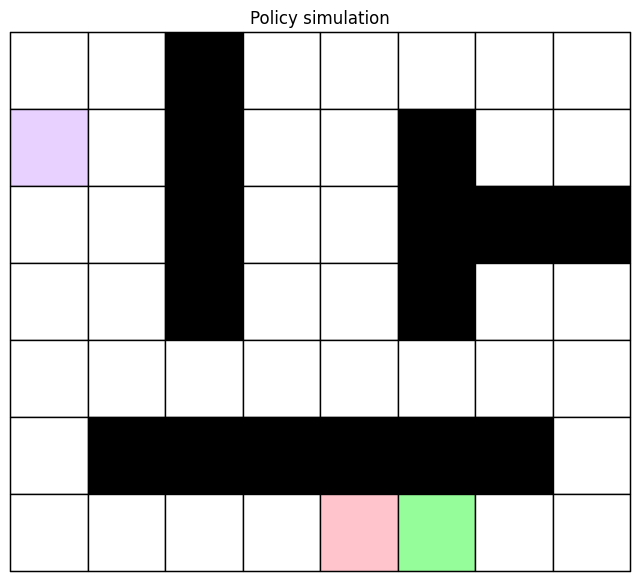

KeyboardInterrupt: 

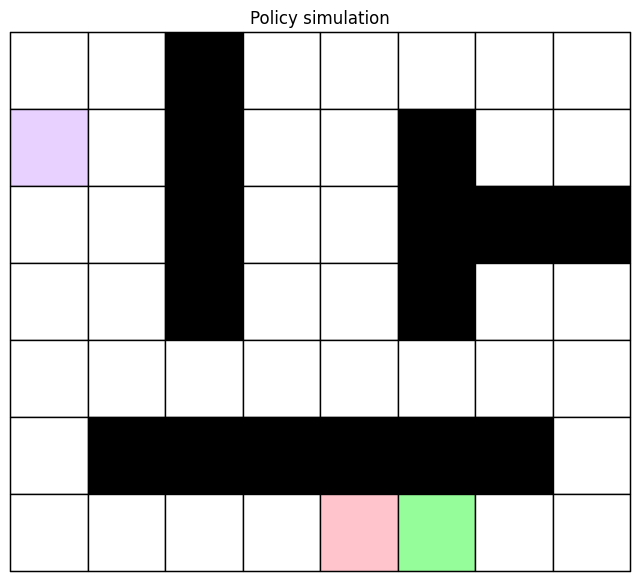

In [25]:
animate_solution(maze, path)